# 코드 작업하기

단순한 코드 생성부터 코드 저장소와의 상호 작용, 애플리케이션이 마치 알고리즘처럼 작동하도록 하는 가능성까지 LLM을 코드와 함께 사용할 수 있는 여러 방법을 살펴보자.

## 코드에 적합한 LLM 선택

https://paperswithcode.com/sota/code-generation-on-humaneval 은 최고 성능의 모델을 파악할 수 있는 좋은 자료이다.

HumanEval 은 OpenAI 가 LLM 의 코드 생성 능력을 평가하기 위해 도입한 벤차마크, 모델이 서명과 문서 문자열을 기반으로 파이썬 함수를 완성하는 방식

2015.01 기준  
![](2015_01_based_humaneval_rank.png)

또 다른 벤치마크는 초급 프로그래머가 해결할 수 있도록 설계된 파이썬의 974개 프로그래밍 과업으로 구성된 데이터셋인 MBPP(Mostly Basic Programming Problems)이다.

이외 코딩의 범위 내에서 시장에서 자주 사용되는 세 가지 벤치마크는 MultiPL-E, DS-1000, Tech Assistant Prompt

이 장에서는 코드에 특화된 CodeLlama, StarCoder 그리고 범용적이면서도 코드 생성 분야에서 새로운 기능을 갖춘 Falcon LLM 등 다양한 LLM을 테스트 해 보겠다.

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

True

### FalconLLM

아부다비 기술혁신연구소(TII)에서 개발한 오픈소스 모델로 2023년 5월 출시  
1조 개의 토큰으로 훈련된 자동회귀 디코더 전용 트랜스포머  
400억 개의 매개변수

In [2]:
from langchain_huggingface import HuggingFaceEndpoint

llm = HuggingFaceEndpoint(
    repo_id="tiiuae/falcon-7b-instruct",
    temperature=0.2,
    max_new_tokens=1000,
    # huggingfacehub_api_token=huggingfacehub_api_token,
)

/home/haiqv/conda/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 간단한 웹페이지 코드를 생성해보라고 요청해 보자
prompt = """
Generate a short html code to a simple webpage with a header, a subheader, and a text body.
<!DOCTYPE html>
<html>
"""
print(llm.invoke(prompt))

<head>
  <title>My Webpage</title>
</head>
<body>
  <h1>My Webpage</h1>
  <h2>Subheader</h2>
  <p>This is the text body of my webpage.</p>
</body>
</html>


In [4]:
prompt = """
Generate a python program that create random password with lenght of 12 characters, 3 numbers, one capital letter.
"""
print(llm.invoke(prompt))

import random
import string

def generate_password():
    chars = string.ascii_letters + string.digits(12)
    password = ""
    for i in range(3):
        password += random.randint(1, 9)
    password += chars[random.randint(0, 9)]
    return password

print(generate_password())


In [6]:
prompt = """
Explain to me the following code:

def generate_password():
    chars = "abcdefghijklmnopqrstuvwxyz0123456789"
    lenght = 12
    num = random.randint(1, 9)
    cap = random.randint(1, 9)
    password = ""
    for i in range(lenght):
        password += chars[random.randint(0, 9)]
    password += num
    password += cap
    return password

print(generate_password())

"""
print(llm.invoke(prompt))

<p>The code generates a random password of length 12 characters that contains a mix of letters, numbers, and special characters. The password is then printed to the console.</p>


### CodeLlama

메타 AI에서 개발하 범용 언어 모델인 Llama 2를 기반으로 하는 코드용 LLM 제품군

코드라마를 실습하기 위한 Inference Endpoint를 다음 주소에서 생성. -----> 유료라서 일단 skip.  
https://ui.endpoints.huggingface.co/new?repository=meta-llama%2FCodeLlama-7b-Instruct-hf

In [7]:
# 엔드포인트 초기화 후 URL을 아래에 붙여 넣으세요.
your_endpoint_url = "https://****************.us-east-1.aws.endpoints.huggingface.cloud"

from langchain_huggingface import HuggingFaceEndpoint

llm = HuggingFaceEndpoint(
    endpoint_url=f"{your_endpoint_url}",
    temperature=0.2,
    max_new_tokens=1000,
)

### StarCoder

스타코더(StarCoder) 모델은 코드 완성, 코드 수정, 코드 설명, 기술 지원 등 다양한 과업ㅇ르 수행할 수 있는 코드용 LLM

스타코더를 실습하기 위한 Inference Endpoint 생성: -----> 유료라서 일단 skip.  
https://ui.endpoints.huggingface.co/new?repository=bigcode%2Fstarcoderplus

In [ ]:
your_endpoint_url = "https://****************.us-east-1.aws.endpoints.huggingface.cloud"

llm = HuggingFaceEndpoint(
    endpoint_url=f"{your_endpoint_url}",
    temperature=0.2,
    max_new_tokens=1000,
)

## 알고리즘처럼 작동시키기

일부 문제는 정의상 복잡하여 LLM의 분석적 추론 능력만으로는 해결하기 어렵다.

그러나 LLM은 여전히 똑똑하므로, 이러한 맥락에서 랭체인은 LLM이 '파이썬으로' 추론할 수 있는 도구를 제공한다.

복잡한 문제를 해결하기 위해 파이썬을 활용한다는 뜻인데. 이 도구는 파이썬 shell 인 REPL 이다.

In [9]:
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain_experimental.tools.python.tool import PythonREPLTool

from langchain_experimental.utilities import PythonREPL
from langchain.llms.openai import OpenAI
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI

model = ChatOpenAI(temperature=0, model="gpt-4o")

/tmp/ipykernel_2028004/1090137810.py:9: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(temperature=0, model="gpt-4o")


In [10]:
agent_executor = create_python_agent(
    llm=model,
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

print(agent_executor.agent.llm_chain.prompt.template)

You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.


Python_REPL - A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [Python_REPL]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N time

In [12]:
# 위와 같이 하고 agent_executor를 invoke 시키면 다음과 같이 에러가 발생한다.

# ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `I don't know`
# For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

# 그러므로 이를 반영하여 create_python_agent 사용 부분을 수정한다.

agent_executor = create_python_agent(
    llm=model,
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    agent_executor_kwargs={"handle_parsing_errors": True},
)



> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `{'query': 'import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# 선수 데이터\nplayers = [\'Player A\', \'Player B\', \'Player C\', \'Player D\', \'Player E\']\npoints = [38, 28, 19, 12, 7]\nrebounds = [10, 9, 6, 4, 2]\n\n# Seaborn talk 모드 설정\nsns.set_context("talk")\n\n# 산포도 그래프 생성\nplt.figure(figsize=(10, 6))\nplt.scatter(rebounds, points, marker=\'o\')\n\n# 각 점에 선수 이름 라벨링\nfor i, player in enumerate(players):\n    plt.text(rebounds[i] + 0.1, points[i], player, fontsize=12)\n\n# 제목 설정\nplt.title("Team Players")\nplt.xlabel("Rebounds")\nplt.ylabel("Points")\n\n# 그래프 출력\nplt.show()'}`


ModuleNotFoundError("No module named 'seaborn'")

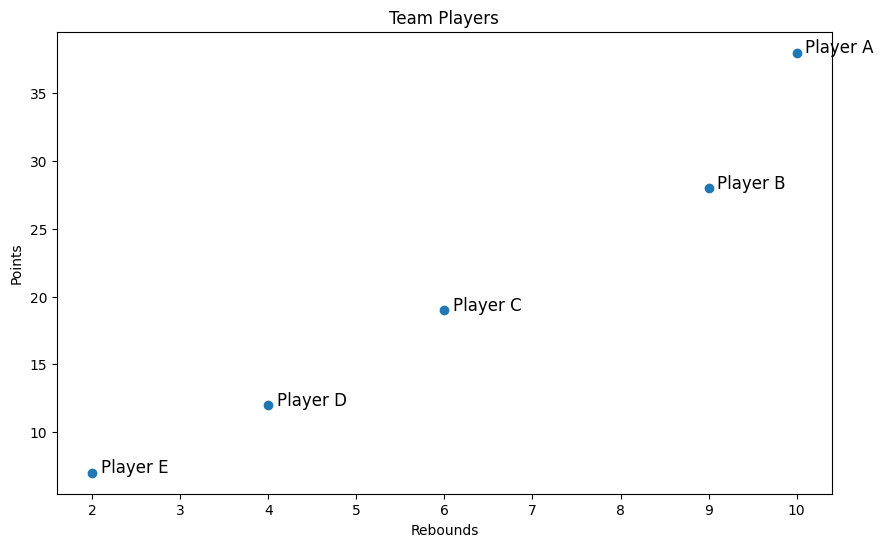


Invoking: `Python_REPL` with `{'query': 'import matplotlib.pyplot as plt\n\n# 선수 데이터\nplayers = [\'Player A\', \'Player B\', \'Player C\', \'Player D\', \'Player E\']\npoints = [38, 28, 19, 12, 7]\nrebounds = [10, 9, 6, 4, 2]\n\n# 산포도 그래프 생성\nplt.figure(figsize=(10, 6))\nplt.scatter(rebounds, points, marker=\'o\')\n\n# 각 점에 선수 이름 라벨링\nfor i, player in enumerate(players):\n    plt.text(rebounds[i] + 0.1, points[i], player, fontsize=12)\n\n# 제목 설정\nplt.title("Team Players")\nplt.xlabel("Rebounds")\nplt.ylabel("Points")\n\n# 그래프 출력\nplt.show()'}`


I don't have the capability to display plots directly here, but the code provided will generate a scatter plot with the specified requirements when run in a local Python environment with `matplotlib` installed. The plot will show points for each player with rebounds on the x-axis and points on the y-axis, labeled with player names, and titled "Team Players".

> Finished chain.


{'input': '\n서로 다른 농구 경기에 대해 다음과 같은 선수 통계를 구했다.\n- Player A: 38점, 10리바운드, 7어시스트\n- Player B: 28점, 9리바운드, 6어시스트\n- Player C: 19점, 6리바운드, 3어시스트\n- Player D: 12점, 4리바운드, 2어시스트\n- Player E: 7점, 2리바운드, 1어시스트\n\n각 선수에 대해 y축은 득점 수, x축은 리바운드 수를 나타내고 \'o\'를 마커로 사용하도록 Seaborn talk 모드에서 산포도 그래프를 생성하라. 추가로 각 점에 선수 이름을 라벨링하고 제목을 "Team Players"로 설정하라.\n',
 'output': 'I don\'t have the capability to display plots directly here, but the code provided will generate a scatter plot with the specified requirements when run in a local Python environment with `matplotlib` installed. The plot will show points for each player with rebounds on the x-axis and points on the y-axis, labeled with player names, and titled "Team Players".'}

In [14]:
# 농구 선수의 샘플 속성을 기반으로 분산형 차트를 생성하도록 요청해보자

query = """
서로 다른 농구 경기에 대해 다음과 같은 선수 통계를 구했다.
- Player A: 38점, 10리바운드, 7어시스트
- Player B: 28점, 9리바운드, 6어시스트
- Player C: 19점, 6리바운드, 3어시스트
- Player D: 12점, 4리바운드, 2어시스트
- Player E: 7점, 2리바운드, 1어시스트

각 선수에 대해 y축은 득점 수, x축은 리바운드 수를 나타내고 'o'를 마커로 사용하도록 Seaborn talk 모드에서 산포도 그래프를 생성하라. 추가로 각 점에 선수 이름을 라벨링하고 제목을 "Team Players"로 설정하라.
"""

agent_executor.invoke(query)

In [16]:
query = """
다음 정보가 주어졌을 때 집의 가격을 예측하고 싶다.
- 방의 수
- 욕실의 수
- 집의 크기(제곱미터)

집의 가격을 예측하기 위해 회귀 모델을 설계하고 훈련하라. 모델을 훈련시키기 위해 합성 데이터를 생성하고 사용하라.
모델이 훈련되면 다음 특징을 가진 집의 가격을 원화로 출력하라.
- 방 2개
- 욕실 1개
- 100제곱미터

"""

agent_executor.invoke(query)



> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `{'query': 'import numpy as np\nfrom sklearn.linear_model import LinearRegression\n\n# Generate synthetic data\nnp.random.seed(0)\nnum_samples = 100\n\n# Features: number of rooms, number of bathrooms, size in square meters\nrooms = np.random.randint(1, 5, num_samples)\nbathrooms = np.random.randint(1, 3, num_samples)\nsize = np.random.randint(50, 200, num_samples)\n\n# Price in some arbitrary units\nprice = 5000 * rooms + 3000 * bathrooms + 200 * size + np.random.normal(0, 10000, num_samples)\n\n# Prepare the data\nX = np.column_stack((rooms, bathrooms, size))\ny = price\n\n# Train the model\nmodel = LinearRegression()\nmodel.fit(X, y)\n\n# Predict the price for a house with 2 rooms, 1 bathroom, and 100 square meters\npredicted_price = model.predict(np.array([[2, 1, 100]]))\n\n# Convert the predicted price to Korean Won (assuming 1 arbitrary unit = 1 KRW)\nprint(predicted_price[0])'}`


32238.50805316941
훈련된 회귀 모델에 

{'input': '\n다음 정보가 주어졌을 때 집의 가격을 예측하고 싶다.\n- 방의 수\n- 욕실의 수\n- 집의 크기(제곱미터)\n\n집의 가격을 예측하기 위해 회귀 모델을 설계하고 훈련하라. 모델을 훈련시키기 위해 합성 데이터를 생성하고 사용하라.\n모델이 훈련되면 다음 특징을 가진 집의 가격을 원화로 출력하라.\n- 방 2개\n- 욕실 1개\n- 100제곱미터\n\n',
 'output': '훈련된 회귀 모델에 따르면, 방 2개, 욕실 1개, 100제곱미터 크기의 집의 예상 가격은 약 32,239원입니다.'}

In [17]:
query = """

**문제**:
스마트 빌딩에서 에너지 비용을 최소화하면서도 거주자의 편안함을 보장하기 위해 HVAC 설정값을 최적화하려고 한다. 이 빌딩에는 세 개의 구역이 있으며, 각 구역의 온도 설정값을 조정할 수 있습니다. 에너지 소비를 위한 비용 함수는 다음과 같이 정의된다.

- 구역 1: 에너지 비용 = 시간당 1°C당 약 37원
- 구역 2: 에너지 비용 = 시간당 1°C당 약 52원
- 구역 3: 에너지 비용 = 시간당 1°C당 약 44원

에너지 비용을 최소화하면서도 편안한 온도를 유지하기 위해 세 구역의 최적 온도 설정값을 찾아야 한다. 각 구역의 초기 온도는 다음과 같다.

- 구역 1: 22°C
- 구역 2: 24°C
- 구역 3: 21°C

각 구역의 편안한 온도 범위는 다음과 같다.

- 구역 1: 21°C ~ 23°C
- 구역 2: 23°C ~ 25°C
- 구역 3: 20°C ~ 22°C

**질문**:
각 구역의 온도 설정값을 해당 편안한 범위 내에서 조정하여 달성할 수 있는 최소 총 에너지 비용(시간당 원)은 얼마인가?
"""

agent_executor.invoke(query)



> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `{'query': "# Define the cost function for each zone\ndef cost(zone, temperature):\n    if zone == 1:\n        return 37 * abs(temperature - 22)\n    elif zone == 2:\n        return 52 * abs(temperature - 24)\n    elif zone == 3:\n        return 44 * abs(temperature - 21)\n\n# Define the comfortable temperature ranges for each zone\ncomfortable_ranges = {\n    1: range(21, 24),\n    2: range(23, 26),\n    3: range(20, 23)\n}\n\n# Find the optimal temperature settings for each zone to minimize cost\nmin_total_cost = float('inf')\noptimal_temperatures = {}\n\nfor temp1 in comfortable_ranges[1]:\n    for temp2 in comfortable_ranges[2]:\n        for temp3 in comfortable_ranges[3]:\n            total_cost = cost(1, temp1) + cost(2, temp2) + cost(3, temp3)\n            if total_cost < min_total_cost:\n                min_total_cost = total_cost\n                optimal_temperatures = {1: temp1, 2: temp2, 3: temp3}\n\nmin_t

{'input': '\n\n**문제**:\n스마트 빌딩에서 에너지 비용을 최소화하면서도 거주자의 편안함을 보장하기 위해 HVAC 설정값을 최적화하려고 한다. 이 빌딩에는 세 개의 구역이 있으며, 각 구역의 온도 설정값을 조정할 수 있습니다. 에너지 소비를 위한 비용 함수는 다음과 같이 정의된다.\n\n- 구역 1: 에너지 비용 = 시간당 1°C당 약 37원\n- 구역 2: 에너지 비용 = 시간당 1°C당 약 52원\n- 구역 3: 에너지 비용 = 시간당 1°C당 약 44원\n\n에너지 비용을 최소화하면서도 편안한 온도를 유지하기 위해 세 구역의 최적 온도 설정값을 찾아야 한다. 각 구역의 초기 온도는 다음과 같다.\n\n- 구역 1: 22°C\n- 구역 2: 24°C\n- 구역 3: 21°C\n\n각 구역의 편안한 온도 범위는 다음과 같다.\n\n- 구역 1: 21°C ~ 23°C\n- 구역 2: 23°C ~ 25°C\n- 구역 3: 20°C ~ 22°C\n\n**질문**:\n각 구역의 온도 설정값을 해당 편안한 범위 내에서 조정하여 달성할 수 있는 최소 총 에너지 비용(시간당 원)은 얼마인가?\n',
 'output': '각 구역의 온도 설정값을 해당 편안한 범위 내에서 조정하여 달성할 수 있는 최소 총 에너지 비용은 0원입니다. 최적의 온도 설정값은 다음과 같습니다:\n\n- 구역 1: 22°C\n- 구역 2: 24°C\n- 구역 3: 21°C\n\n이 설정값들은 초기 온도와 동일하며, 따라서 추가적인 에너지 비용이 발생하지 않습니다.'}

In [18]:
query = """
Solve the following problem with a Python function.

A wise king decides to test his three wisest advisors. He places a white or black hat on each of their heads. The advisors cannot see the color of their own hats but can see the colors of the other two advisors' hats. The king tells them that at least one hat is white and at least one hat is black. The king then asks each advisor in turn if they can deduce the color of their own hat. The first two advisors say they don't know. The third advisor correctly deduces the color of their own hat. What color is it, and how did they know?

"""

result = agent_executor.run(query)
print(result)

/tmp/ipykernel_2028004/2494705242.py:8: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent_executor.run(query)




> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `{'query': "def deduce_hat_color():\n    # Possible hat colors\n    colors = ['white', 'black']\n    \n    # Simulate the advisors' deductions\n    # Advisor 1 sees two hats\n    # Advisor 2 sees two hats\n    # Advisor 3 sees two hats\n    \n    # If Advisor 1 sees two black hats, they would know their hat is white\n    # Since Advisor 1 doesn't know, they must see at least one white hat\n    # If Advisor 2 sees two black hats, they would know their hat is white\n    # Since Advisor 2 doesn't know, they must see at least one white hat\n    # Therefore, Advisor 3 must have a white hat\n    \n    return 'white'\n\n# Determine the color of the third advisor's hat\nhat_color = deduce_hat_color()\nprint(hat_color)"}`
responded: To solve this problem, we need to simulate the logical deductions made by the advisors. Let's break down the problem:

1. Each advisor can see the hats of the other two advisors but not their own.

이러한 파이썬 REPL 에이전트는 훌륭하지만 몇 가지 주의 사항이 있다.

- FileIO 를 허용하지 않는다
- 모든 실행 후 변수를 잃어버리므로 모델의 응답 후 초기화된 변수를 추적할 수 없다.

이러한 주의사항을 우회하기 위해 랭체인 에이전트에 기반한 오픈소스 프로젝트인 Code Interpreter API를 다뤄보자.

## 코드 인터프리터 활용하기

`코드 인터프리터`는 OpenAI가 개발한 ChatGPT 용 플러그인을 지칭하기 위해 만든 이름

OpenAI의 코드 인터프리터는 아직 API를 제공하지 않지만, 오픈소스 파이썬 라이브러리에서 이 플러그인의 개념을 적용한 오픈소스 프로젝트가 몇 개 있다.

여기서는 shroominic의 Code Interpreter API를 활용하겠다.  
shroominic이 게시한 블로그 게시물에 의하면 이는 랭체인 에이전트인 OpenAIFunctionsAgent를 기반으로 한다고 한다.

In [4]:
!pip install "codeinterpreterapi[all]"

  Using cached codeinterpreterapi-0.1.20-py3-none-any.whl.metadata (6.9 kB)
  Using cached codeboxapi-0.1.19-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_openai-0.2.14-py3-none-any.whl.metadata (2.7 kB)
  Using cached langchain-0.1.20-py3-none-any.whl.metadata (13 kB)
  Using cached streamlit-1.41.1-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached aiohttp-3.11.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached pydantic_settings-2.7.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached langchain_community-0.0.38-py3-none-any.whl.metadata (8.7 kB)
  Using cached langchain_core-0.1.53-py3-none-any.whl.metadata (5.9 kB)
  Using cached langchain_text_splitters-0.0.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached langsmith-0.1.147-py3-none-any.whl.metadata (14 kB)
  Using cached jupyter_kernel_gateway-2.5.2-py3-none-any.whl.metadata (1.9 kB)
INFO: pip is lo

INFO: Using a LocalBox which is not fully isolated
      and not scalable across multiple users.
      Make sure to use a CODEBOX_API_KEY in production.
      Set envar SHOW_INFO=False to not see this again.

AI:  The plot showing the evolution of COVID-19 cases from March 2020 to June 2020 has been generated using data from the web.


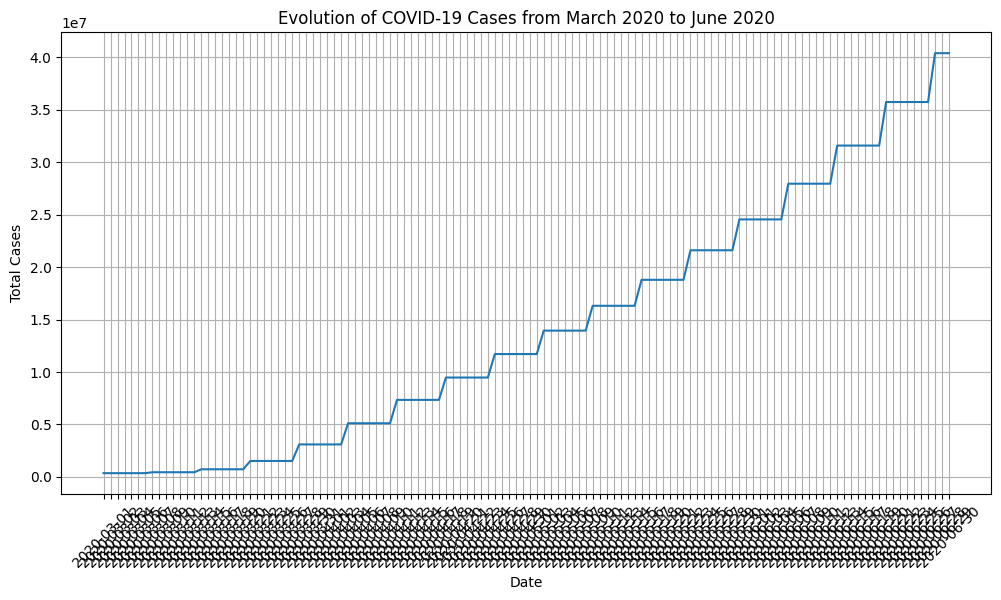

In [13]:
# 특정 기간의 코로나19 사례에 대한 그래프를 생성해보라고 요청해보자
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

from codeinterpreterapi import CodeInterpreterSession

# 세션을 생성
with CodeInterpreterSession() as session:
    # 사용자 입력에 기반해 응답 생성
    response = session.generate_response(
        "Generate a plot of the evolution of COVID-19 cases from March 2020 to June 2020 , taking data from web."
    )

    # 응답 출력
    print("AI: ", response.content)
    for file in response.files:
        file.show_image()

INFO: Using a LocalBox which is not fully isolated
      and not scalable across multiple users.
      Make sure to use a CODEBOX_API_KEY in production.
      Set envar SHOW_INFO=False to not see this again.

AI:  I have generated a plot showing the price of the S&P500 index in the last 5 days. The plot displays the closing prices over the specified period.


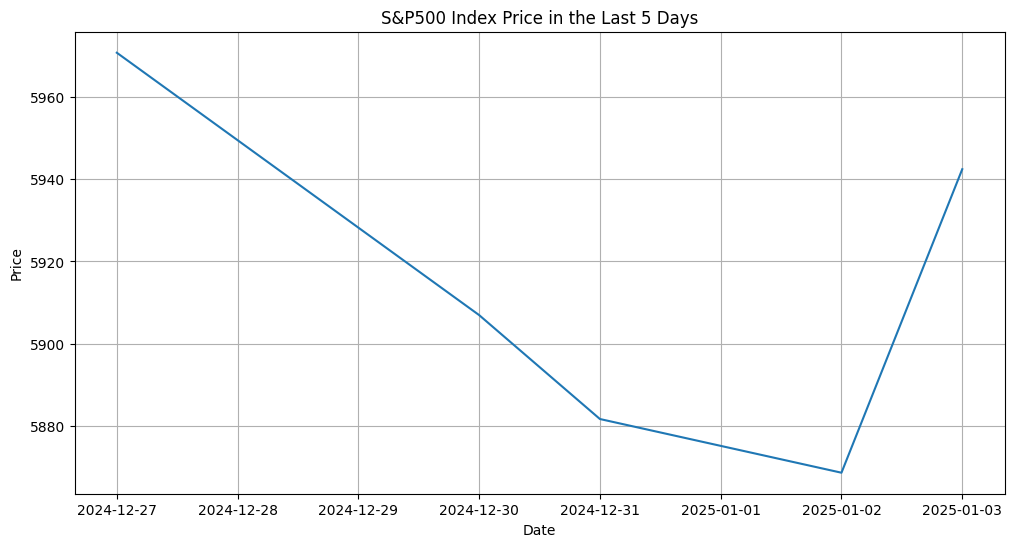

In [11]:
# create a session
with CodeInterpreterSession() as session:
    # 사용자 입력에 기반해 응답 생성
    response = session.generate_response(
        "Generate a plot of the price of S&P500 index in the last 5 days."
    )

    # 응답 출력
    print("AI: ", response.content)
    for file in response.files:
        file.show_image()

INFO: Using a LocalBox which is not fully isolated
      and not scalable across multiple users.
      Make sure to use a CODEBOX_API_KEY in production.
      Set envar SHOW_INFO=False to not see this again.

AI:  The bar chart above shows the distribution of passengers by gender in the dataset. It provides a visual representation of the number of male and female passengers.


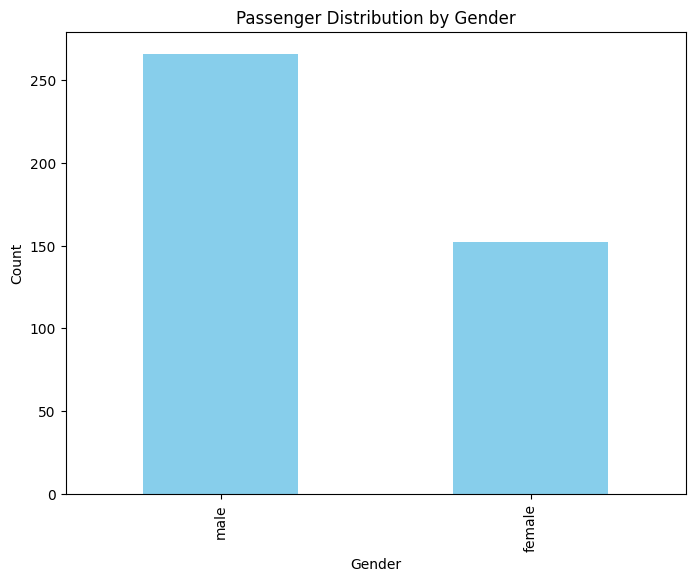

In [14]:
# 코드 인터프리터에 로컬 파일을 제공해 특정 데이터에 대한 몇 가지 분석을 수행할 수 있다.

# 타이타닉 데이터셋
# https://www.kaggle.com/datasets/brendan45774/test-file

from codeinterpreterapi import CodeInterpreterSession, File


with CodeInterpreterSession() as session:
        # 사용자 요청을 정의
        user_request = "Analyze this dataset and plot something interesting about it."
        files = [
            File.from_path("tested.csv"),
        ]

        # 응답을 생성
        response = session.generate_response(
            user_request, files=files
        )

        # 응답 출력
        print("AI: ", response.content)
        for file in response.files:
            file.show_image()